<a href="https://colab.research.google.com/github/amandadotkom/Bachelor-Project-2023-2024/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports
Always run these cells

In [ ]:
'''
The files used for this project was stored in Google Drive
'''

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Imports
import pandas as pd
import re
import numpy as np
from collections import Counter
import nltk
from nltk.util import ngrams

## Loading, cleaning, and transforming

Loading the data for the first time, text data cleaning and transformation

###Loading dataset

Read entry file

In [ ]:
'''
File location should be changed accordingly
'''
filepath = '/content/drive/MyDrive/Bachelor Project 2023/Data/selection_FIC_Juv.txt'
data = pd.read_csv(filepath, sep='delimiter', header=None, encoding = 'utf-8')
data.set_axis(['text'], axis='columns', inplace=True)
data.head()

<ipython-input-115-7c2b13559d5c>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(filepath, sep='delimiter', header=None, encoding = 'utf-8')
<ipython-input-115-7c2b13559d5c>:6: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data.set_axis(['text'], axis='columns', inplace=True)


,text
0,@@4121408 Mary Jane woke up excited . She had ...
1,@@4121411 Earth has become too polluted to liv...
2,"@@4121413 "" Perfect storm ? Lefs show them ! ""..."
3,"@@4121415 BE CAREFUL WHAT YOU WISH FOR , IT MI..."
4,"@@4121428 When the Mee family moves , they get..."


Read lemma file

In [ ]:
'''
Again, the filepath should be adjusted accordingly
'''
filepath_lemma = '/content/drive/MyDrive/Bachelor Project 2023/Data/selection_wlp_FIC_Juv.txt'
lemma_file = pd.read_csv(filepath_lemma, sep='delimiter', header=None, encoding='utf-8')

<ipython-input-116-082ed771aaa6>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  lemma_file = pd.read_csv(filepath_lemma, sep='delimiter', header=None, encoding='utf-8')


In [ ]:
lemma_file.head()

,0
0,1008629\t@@1008629
1,1008629\tWORLD\tworld\tnn1
2,1008629\tHISTORY\thistory\tnn1
3,1008629\tPLAY\tplay\tnn1_vv0
4,1008629\tHeadnote\theadnote\tnn1


Transforming all data to a dataframe

In [ ]:
#Selecting only the lines with the id, word, lemmas and pos
lemmas = [line for idx, line in enumerate(lemma_file[0]) if len(lemma_file[0][idx].split('\t')) == 4]

In [ ]:
lemma_df = pd.DataFrame([line.split('\t') for line in lemmas], columns=['id', 'word', 'lemma', 'pos'])

In [ ]:
lemma_df.head()

,id,word,lemma,pos
0,1008629,WORLD,world,nn1
1,1008629,HISTORY,history,nn1
2,1008629,PLAY,play,nn1_vv0
3,1008629,Headnote,headnote,nn1
4,1008629,From,from,ii


In [ ]:
# Store all the fictional document IDs in a list
docs = data['text'] # docs is just a placeholder
ids = []
idx = 0
for ID in docs:
  word = docs[idx].split()
  id = re.sub(r'@@', '', word[0]) # get rid of the @@ before the ID
  ids.append(id)
  idx += 1


In [ ]:
# Make dataframe that has the ID of the entry on one column, and the corresponding text from that entry on the other column

id_and_text = pd.DataFrame(list(zip(ids, docs)))
id_and_text.set_axis(['id', 'text'], axis='columns', inplace=True)


id_and_text.head()

<ipython-input-122-f0bc0ab10586>:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  id_and_text.set_axis(['id', 'text'], axis='columns', inplace=True)


,id,text
0,4121408,@@4121408 Mary Jane woke up excited . She had ...
1,4121411,@@4121411 Earth has become too polluted to liv...
2,4121413,"@@4121413 "" Perfect storm ? Lefs show them ! ""..."
3,4121415,"@@4121415 BE CAREFUL WHAT YOU WISH FOR , IT MI..."
4,4121428,"@@4121428 When the Mee family moves , they get..."


###Lemmatization

Take the id and lemma columns from the 'lemma' dataframe

In [ ]:
only_lemma = lemma_df[['id', 'lemma']].copy()

In [ ]:
only_lemma.head()

,id,lemma
0,1008629,world
1,1008629,history
2,1008629,play
3,1008629,headnote
4,1008629,from


Change the layout of the dataframe so that all words from the same entry (id) is in the same row with the entry

In [ ]:
# Function to concatenate words in a list
def concatenate_words(word_list):
    return ' '.join(str(word) for word in word_list) # some values are not strings in the lemma data

def group_lemma(df):
  grouped = df.groupby('id')['lemma'].agg(list).reset_index() # groups the words according to the id
  grouped['lemma'] = grouped['lemma'].apply(concatenate_words) # join the words so it becomes a full text

  return grouped

only_lemma = group_lemma(only_lemma)

In [ ]:
only_lemma.head()

,id,lemma
0,1000010,a honorable little gentleman a accidental meet...
1,1000012,in a different dress <p> elizabeth plod down t...
2,1000016,these kid think that lose their school would b...
3,1000018,jim carrey have a new and furry ! <p> you read...
4,1000019,a beastly creature . a haunting sound . a puzz...


###Data cleaning and transforming

General cleaning function for irrelevant characters and makes the words lower case

In [ ]:
# Based on https://www.kaggle.com/code/boldy717/textual-data-exploration-with-n-grams
# Aposthropes kept so that i can link each token to the lemma provided by coca, e.g, 's in "let 's" is one token.
def clean(documents):
    cleaned_text = []
    for document in documents:
        s = re.sub(r'<.*?>', '', document) # Removes the <p>
        s = re.sub(r'nan', '', s) # Removes any NAN values
        s = re.sub(r'(\w+)-(\w+)', r'\1 \2', s)  # Replace hyphen between words with space
        s = re.sub(r'\?', '.', s)  # Replace question marks with periods
        s = re.sub(r'\!', '.', s)  # Replace exclamation marks with periods
        s = re.sub(r'[^a-zA-Z\s.\']', '', s) # non alphanumeric or whitespaces, keeps periods and aposthropes so sentence structure remains
        s = re.sub('\s+',' ', s)
        s = str(s).lower()
        tokens = [token for token in s.split(" ") if token != ""]
        entry = ' '.join(tokens)
        cleaned_text.append(entry)
    return(cleaned_text)

In [ ]:
# Replce the text column with cleaned version
id_and_text['text'] = clean(id_and_text['text'])

In [ ]:
# Replace lemma column with cleaned version
only_lemma['lemma'] = clean(only_lemma['lemma'])

In [ ]:
lemma_df['word'] = clean(lemma_df['word'])
lemma_df['lemma'] = clean(lemma_df['lemma'])

Get rid of empty rows in lemma_df

In [ ]:
def remove_empty_str(df, column_name):
    # Drop rows where the specified column has an empty string (because of the cleaning process)
    df_filtered = df[df[column_name] != '']
    df_filtered = df_filtered.reset_index(drop=True)
    return df_filtered

In [ ]:
lemma_df = remove_empty_str(lemma_df, 'word')

In [ ]:
lemma_df

,id,word,lemma,pos
0,1008629,world,world,nn1
1,1008629,history,history,nn1
2,1008629,play,play,nn1_vv0
3,1008629,headnote,headnote,nn1
4,1008629,from,from,ii
...,...,...,...,...
3366440,1036462,not,not,xx
3366441,1036462,buying,buy,vvg
3366442,1036462,the,the,at
3366443,1036462,car,car,nn1


Split the text in the dataframe to sentences

In [ ]:
# for form {ID : all sentences from that ID}
def split_sentences(df):
  for idx, item in enumerate(df.iloc[:, 1]):
    df.iloc[:, 1][idx] = df.iloc[:, 1][idx].split('.')

In [ ]:
split_sentences(id_and_text)

In [ ]:
split_sentences(only_lemma)

In [ ]:
only_lemma.head()

,id,lemma
0,1000010,[a honorable little gentleman a accidental mee...
1,1000012,[in a different dress elizabeth plod down the ...
2,1000016,[these kid think that lose their school would ...
3,1000018,"[jim carrey have a new and furry , you read i..."
4,1000019,"[a beastly creature , a haunting sound , a p..."


In [ ]:
id_and_text.head()

,id,text
0,4121408,"[mary jane woke up excited , she had barely s..."
1,4121411,"[earth has become too polluted to live on , t..."
2,4121413,"[perfect storm , lefs show them , said the u..."
3,4121415,[be careful what you wish for it might come tr...
4,4121428,[when the mee family moves they get a big back...


Make a dictionary that links each word to its lemma.

This step was done in case the lemma of a certain word is needed.

In [ ]:
def make_dict(df, key_col, val_col):
  new_dict = {}
  for row in range(len(df)):
      key = df.loc[row, key_col]
      value = str(df.loc[row, val_col])
      new_dict[key] = value
  return new_dict

In [ ]:
lemma_dict = make_dict(lemma_df, 'word', 'lemma')

###Save dataframes with each entry and their corresponding text or lemmatized text

In [ ]:
import os
id_and_text.to_csv('/content/drive/MyDrive/Bachelor Project 2023/Data/text.csv')
only_lemma.to_csv('/content/drive/MyDrive/Bachelor Project 2023/Data/only_lemma.csv')

In [ ]:
import pickle

with open('/content/drive/MyDrive/Bachelor Project 2023/Data/lemma_dict.pkl', 'wb') as file:
    pickle.dump(lemma_dict, file)

##Start

###Loading previously preprocessed data

Load entry:text dataframes

In [ ]:
# https://saturncloud.io/blog/how-to-read-csv-containing-a-list-in-pandas/#:~:text=Reading%20CSV%20Files%20Containing%20Lists,list%20to%20an%20actual%20list.
# Reading the csv dataframe, using function below so that the 'text' column will be read in as a list instead of a string

import ast

def str_to_list(s):
    return ast.literal_eval(s)

In [ ]:
text = pd.read_csv('/content/drive/MyDrive/Bachelor Project 2023/Data/text.csv', encoding = 'utf-8', index_col=0, converters={'text': str_to_list})

In [ ]:
only_lemma = pd.read_csv('/content/drive/MyDrive/Bachelor Project 2023/Data/only_lemma.csv', encoding = 'utf-8', index_col=0, converters={'lemma': str_to_list})

In [ ]:
text.head()

In [ ]:
only_lemma.head()

Load word:lemma dictionary

In [ ]:
import pickle
with open('/content/drive/MyDrive/Bachelor Project 2023/Data/lemma_dict.pkl', 'rb') as file:
    lemma_dict = pickle.load(file)

###Filtering (filtering irrelevant words/sentences)

Filtering was done after data cleaning since the filtering process included some trial and errors; irrelevant phrases were discovered throughout the process so they were not known from the start.

In [ ]:
def filter(df, column, phrase):
  df[column] = df[column].apply(lambda sentences: [re.sub(re.escape(phrase), '', sentence, flags=re.IGNORECASE) for sentence in sentences])
  return df

In [ ]:
'''
 These phrases emerged in the top of the N-gram lists very frequently. These are
 clearly not idiomatic so they were removed to allow more space to other
 potential idiomatic N-grams
'''

phrases_to_filter = [
    'narrator n',
    'people who tell the story',
    'write your initials next to the character you \'re going to read',
    'starred characters are major roles',
    'sign up for the character you \'re going to read',
    'the character you \'re going to',
    'look for context clues to learn these',
    'see parentheses'
]

phrases_to_filter_lm = [
    'the character you be go to',
    'character you be go to read',
    'up for the character you be',
    'character sign up for the character',
    'write your initial next to the',
    'scene narrator'
]


for phrase in phrases_to_filter:
    text = filter(text, 'text', phrase)

for phrase in phrases_to_filter_lm:
  only_lemma = filter(only_lemma, 'lemma', phrase)

In [ ]:
text.head()

##Finding N-Grams

### Finding n-grams and storing them

In [ ]:
def get_ngrams(li, n):
  #takes in a list of sentences and n for n-gram
  # iterates thru list
  n_grams = []
  for idx, sentence in enumerate(li):
    words = sentence.split()
    if len(words) >= n: # skip sentences that are shorter than the n-gram
      ng = ngrams(words, n) # gets n grams of the sentence, creates combos of those n grams in a list
      joined_ngrams = [' '.join(gram) for gram in ng] # convert the tuples in the ngrams zip to a string
      n_grams.extend(joined_ngrams) # add the n gram strings to the list
  return n_grams

In [ ]:
def store_ngrams(data, n):
  new_df = data.copy()
  for entry in range(len(data.iloc[:, 1])):
    new_df.iloc[:, 1][entry] = get_ngrams(data.iloc[:, 1][entry], n)

  return new_df

In [ ]:
trigrams = store_ngrams(text, 3)
lemma_trigrams = store_ngrams(only_lemma, 3)

fourgrams = store_ngrams(text, 4)
lemma_fourgrams = store_ngrams(only_lemma, 4)

fivegrams = store_ngrams(text, 5)
lemma_fivegrams = store_ngrams(only_lemma, 5)

sixgrams = store_ngrams(text, 6)
lemma_sixgrams = store_ngrams(only_lemma, 6)

sevengrams = store_ngrams(text, 7)
lemma_sevengrams = store_ngrams(only_lemma, 7)

eightgrams = store_ngrams(text, 8)
lemma_eightgrams = store_ngrams(only_lemma, 8)

ninegrams = store_ngrams(text, 9)
lemma_ninegrams = store_ngrams(only_lemma, 9)

tengrams = store_ngrams(text, 10)
lemma_tengrams = store_ngrams(only_lemma, 10)

Make the found n-grams a list

In [ ]:
# Put items (n-grams) in the dataframe 'Text' column to one list
def make_list(df):
  listy = []
  for entry in range(len(df.iloc[:, 1])): # For each entry
    for ng in df.iloc[:, 1][entry]:
      listy.append(ng)

  return listy

Normal text N-grams to list

In [ ]:
# Each list contains all the n-grams from the entire dataset
trigrams_list = make_list(trigrams)
fourgrams_list = make_list(fourgrams)
fivegrams_list = make_list(fivegrams)
sixgrams_list = make_list(sixgrams)
sevengrams_list = make_list(sevengrams)
eightgrams_list = make_list(eightgrams)
ninegrams_list = make_list(ninegrams)
tengrams_list = make_list(tengrams)

Lemmatized text N-grams to list

In [ ]:
# Each list contains all the n-grams from the entire dataset
trigrams_list_lm = make_list(lemma_trigrams)
fourgrams_list_lm = make_list(lemma_fourgrams)
fivegrams_list_lm = make_list(lemma_fivegrams)
sixgrams_list_lm = make_list(lemma_sixgrams)
sevengrams_list_lm = make_list(lemma_sevengrams)
eightgrams_list_lm = make_list(lemma_eightgrams)
ninegrams_list_lm = make_list(lemma_ninegrams)
tengrams_list_lm = make_list(lemma_tengrams)

In [ ]:
# Number of N-grams from the original text
print(len(trigrams_list)+
len(fourgrams_list)+
len(fivegrams_list)+
len(sixgrams_list)+
len(sevengrams_list)+
len(eightgrams_list)+
len(ninegrams_list)+
len(tengrams_list))

13066464


In [ ]:
# Number of N-grams from the lemmatized text
print(len(trigrams_list)+
len(fourgrams_list_lm)+
len(fivegrams_list_lm)+
len(sixgrams_list_lm)+
len(sevengrams_list_lm)+
len(eightgrams_list_lm)+
len(ninegrams_list_lm)+
len(tengrams_list_lm))

13199428


###To find most frequent n-grams from the n-gram list + pruning

In [ ]:
# Use Counter function
# https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(li, baseline, min_occur):
    top_dict = {}
    top_list = []
    occurence_count = Counter(li) # dictionary consisting of word and its count

    # most_common() gets (baseline) number of most frequent items
    for word, freq in occurence_count.most_common(baseline):
      if freq >= min_occur: # at least occurs more than (min)
        top_dict[word] = freq
        top_list.append(word)

    return top_dict, top_list

Prune the list from irrelevant tokens

In [ ]:
# removes sentences from the list if it matches or partially matches the phrase
def prune(dicty, phrase):
  pruned_list = []
  pruned_dict = {}

  for sentence, value in dicty.items():
      if not re.search(re.escape(phrase), sentence, flags=re.IGNORECASE):
          pruned_list.append(sentence)
          pruned_dict[sentence] = value

  return pruned_dict, pruned_list

In [ ]:
'''
"For trigrams" should be uncommented when generating the trigrams. It has special
tokens to remove since these tokens were more common in trigrams. Since
trigrams are short, having these tokens are not informatinve
(e.g, "run to the").
'''

pruned_phrases = [
  ' i ',
  'i \'ve',
  'i \'m',
  'you \'ve',
  'you',
  ' me ',
  ' we ',
  ' us ',
  'narrator',
  'did n\'t',
  'do n\'t',
  'had n\'t',
  'parentheses',
  'photo color',
  'teaching objectives',
  'prep strategy',
  'bubble',
  'discussion questions',
  'writing response',
  'notice which type of question',
  'students should be able'
]

pruned_phrases_lemma = [
  ' i ',
  'i\'ve',
  'i \'m',
  ' you ',
  'you \'ve',
  ' me ',
  ' we ',
  ' us ',
  'did n\'t',
  'do n\'t',
  'had n\'t',
  'would n\'t',
  'was n\'t'
  'narrator',
  'parentheses',
  'color photo',
  'teaching objective',
  'prep strategy',
  'bubble',
  'discussion question',
  'wrting response',
  'notice which type of question',
  'student should be able'
]

Exploring the optimal minoccur parameter value

In [ ]:
def explore_minoccur(a, b, ngram_list, ngram_list_lm):
  minoccur = []
  top = []
  top_lemma = []
  pruned = []
  pruned_lemma = []

  for n in range(a, b+1):
    top_dict, prune_dict, top_dict_lm, prune_dict_lm = find(ngram_list, ngram_list_lm, 200000, n)
    top.append(len(top_dict))
    top_lemma.append(len(top_dict_lm))
    pruned.append(len(prune_dict))
    pruned_lemma.append(len(prune_dict_lm))
    minoccur.append(n)

  return top, pruned, top_lemma, pruned_lemma, minoccur

In [ ]:
top, pruned, top_lemma, pruned_lemma, minoccur = explore_minoccur(5, 60, fivegrams_list, fivegrams_list_lm)

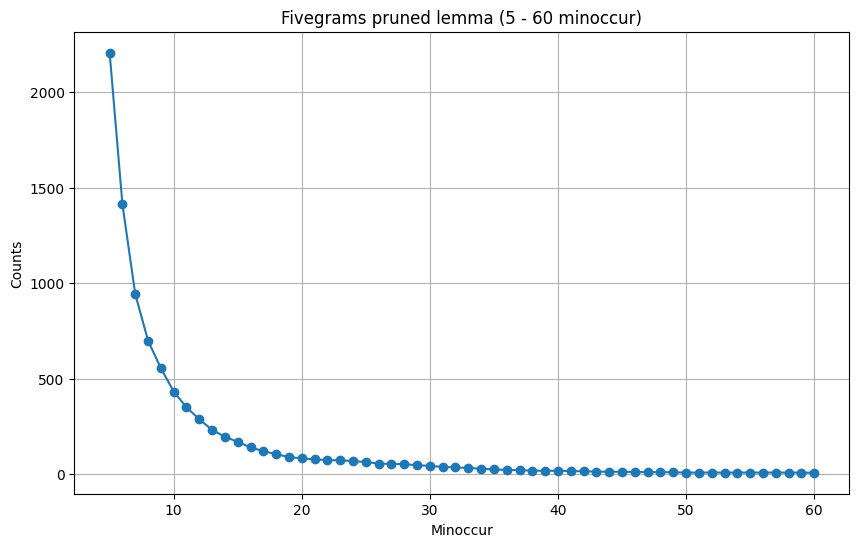

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(minoccur, pruned_lemma, '-o')
plt.title("Fivegrams pruned lemma (5 - 60 minoccur)")
plt.xlabel("Minoccur")
plt.ylabel("Counts")
plt.grid(True)

plt.show()

Automate process of finding the most frequent n_grams and pruning them

In [ ]:
'''
Returns a dictionary of the top n-grams (and lemmatized) from the data and their
respective counts, as well as the pruned version of the dictionaries.
'''

def find(ngram_list, ngram_list_lm, min_occur, pruned_phrases=pruned_phrases, pruned_phrases_lemma=pruned_phrases_lemma):
  top_dict, top_list = most_frequent(ngram_list, baseline, min_occur)
  top_dict_lm, top_list_lm = most_frequent(ngram_list_lm, baseline, min_occur)

  prune_dict, prune_list = top_dict, top_list
  prune_dict_lm, prune_list_lm = top_dict_lm, top_list_lm

  for phrase in pruned_phrases:
    prune_dict, prune_list = prune(prune_dict, phrase)

  for phrase in pruned_phrases_lemma:
    prune_dict_lm, prune_list_lm = prune(prune_dict_lm, phrase)

  return top_dict, prune_dict, top_dict_lm, prune_dict_lm

In [ ]:
'''
The n-gram list should be adjusted to the desired N, in the follwing format:
'{n-gram}_list' or '{n-gram}_list_lm' for the lemmatized version. For example,
'trigrams_list' or 'trigrams_list_lm'.

The n-gram names are: trigrams, fourgrams, fivegrams, and so on; until tengrams.

The baseline parameter is arbitrarily set to
'''

ngram_list = trigrams_list
ngram_list_lm = trigrams_list_lm

top_dict, prune_dict, top_dict_lm, prune_dict_lm = find(ngram_list, ngram_list_lm, _, 13)
print(len(top_dict), len(top_dict_lm))

1883 2684


In [ ]:
print(len(prune_dict), len(prune_dict_lm))

1299 2119


###Save list

In [ ]:
def save_as_txt(top_dict, name):
    filepath = f'/content/drive/MyDrive/Bachelor Project 2023/Data/Top/{name}.txt'
    with open(filepath, 'w') as file:
        for ngram, frequency in top_dict.items():
            file.write(f"{ngram} {frequency}\n")

In [ ]:
# save_as_txt(b, 'trigrams_minoccur50')
save_as_txt(prune_dict, 'fourgrams_minoccur13')
save_as_txt(prune_dict_lm, 'fourgrams_lemma_minoccur13')

##Visualization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
'''
The top idioms.csv was manually made because the figurative frequency calculation was made outside the program.
The idioms found were only in books or magazines. Movie scripts and plays were therefore not included in the data table.
'''
import pandas as pd

#filename should be adjusted to the location of idiom csv file.
dat = pd.read_csv('/content/drive/MyDrive/Bachelor Project 2023/Data/final idiom list.csv', encoding='utf-8', header=0)

In [ ]:
dat

In [ ]:
# Number of occurrences is books and magazines
print('book: ' + str(sum(dat['book'])))
print('mag: ' +  str(sum(dat['mag'])))

In [ ]:
# # Median
raw_median = dat['raw frequency']. median()
figurative_median = dat['fig. frequency']. median()

raw_median, figurative_median

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# plt.figure(figsize=(11, 25))

# ranks = np.arrange(len[dat['fig. frequency']])
# plt.figure(figsize=(10, 6))
# plt.loglog(ranks, dat['raw frequency''], marker='o', linestyle='-', color='b')

# plt.title('Log-Log plot of Frequency vs Rank')
# plt.xlabel('Rank (log scale)')
# plt.ylabel('Frequency (log scale)')

# # Adding gridlines for better readability
# plt.grid(True, which="both", ls="--")

# # Show the plot
# plt.show()

In [ ]:
# The following code is partially based on code by ChatGPT 4.0
# Re-importing necessary libraries after a reset
import pandas as pd
import matplotlib.pyplot as plt

# Sort the dataframe by 'final frequency' in descending order
freq_plot = dat.sort_values(by='fig. frequency')

# Create the plot with bars on the y-axis
plt.figure(figsize=(11, 25))
bars = plt.barh(freq_plot['idiom'], freq_plot['fig. frequency'], color='pink', edgecolor='black')
plt.xlim(0, 200)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, round(width, 0), va='center', fontsize='x-large')

# Set the x and y axis labels
plt.ylabel('Idiom',  fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.yticks(fontsize=18)


# Set the title of the plot
plt.title('Figurative frequency of Idiomatic Phrases in COCA Juvenile Fiction (1990-present)', fontsize=20)

# Add a caption for asterisks
plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=16)

# Adjust layout to prevent clipping of ylabel and ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Re-importing necessary libraries after a reset
import pandas as pd
import matplotlib.pyplot as plt

# Sort the dataframe by 'final frequency' in descending order
freq_plot = dat[0:10].sort_values(by='fig. frequency')

# Create the plot with bars on the y-axis
plt.figure(figsize=(14, 13))
bars = plt.barh(freq_plot['idiom'], freq_plot['fig. frequency'], color='pink', edgecolor='black')
plt.xlim(0, 250)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, round(width, 0), va='center', fontsize='x-large')

# Set the x and y axis labels
plt.ylabel('Idiom', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Frequency', fontsize=18)

# Set the title of the plot
plt.title('Figurative Frequency of Top 10 Idiomatic Phrases  in COCA Juvenile Fiction (1990-present)', fontsize=20)

# Add a caption for asterisks
plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=15)

# Adjust layout to prevent clipping of ylabel and ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Re-importing necessary libraries after a reset
import pandas as pd
import matplotlib.pyplot as plt

# Sort the dataframe by 'final frequency' in descending order
freq_plot = dat.sort_values(by='raw frequency')

# Create the plot with bars on the y-axis
plt.figure(figsize=(11, 25))
bars = plt.barh(freq_plot['idiom'], freq_plot['raw frequency'], color='lightblue', edgecolor='black')
plt.xlim(0, 250)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, round(width, 0), va='center', fontsize='x-large')

# Set the x and y axis labels
plt.ylabel('Idiom', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Frequency', fontsize=18)

# Set the title of the plot
plt.title('Idiomatic Phrases in COCA Juvenile Fiction (1990-present)', fontsize=20)

# Add a caption for asterisks
plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=15)

# Adjust layout to prevent clipping of ylabel and ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Re-importing necessary libraries after a reset
import pandas as pd
import matplotlib.pyplot as plt

# Sort the dataframe by 'final frequency' in descending order
freq_plot = dat[0:10].sort_values(by='raw frequency')

# Create the plot with bars on the y-axis
plt.figure(figsize=(14, 13))
bars = plt.barh(freq_plot['idiom'], freq_plot['raw frequency'], color='lightblue', edgecolor='black')
plt.xlim(0, 250)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, round(width, 0), va='center', fontsize='x-large')

# Set the x and y axis labels
plt.ylabel('Idiom', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Frequency', fontsize=18)

# Set the title of the plot
plt.title('Top 10 Idiomatic Phrases in COCA Juvenile Fiction (1990-present)', fontsize=20)

# Add a caption for asterisks
plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=15)

# Adjust layout to prevent clipping of ylabel and ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Code partially generated by ChatGPT 4.0

import numpy as np

# We will plot grouped bar chart for raw frequency and final frequency
fig, ax = plt.subplots(figsize=(11, 25))

# Define the y-axis and the height of the bars
freq_plot = dat.sort_values(by='raw frequency', ascending=True)
idioms = freq_plot['idiom']
y = np.arange(len(idioms))
bar_height = 0.35

# plot both 'raw frequency' and 'fig. frequency' bars horizontally
ax.barh(y - bar_height/2, freq_plot['raw frequency'], height=bar_height, label='Raw Frequency', color='lightblue', edgecolor='black')
ax.barh(y + bar_height/2, freq_plot['fig. frequency'], height=bar_height, label='Figurative Frequency', color='pink', edgecolor='black')


# Set the labels and title
ax.set_ylabel('Idiom', fontsize=18)
ax.set_xlabel('Frequency', fontsize=18)
ax.set_title('Comparison of Raw Frequency and Figurative Frequency', fontsize=18)

plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=16)

# Set the y-ticks to be in the middle of the two groups of bars for each idiom
ax.set_yticks(y)
ax.set_yticklabels(idioms, fontsize=14)

# Adjust the view limit if needed
ax.set_ylim(-1, len(idioms))

# Adding a legend to distinguish between the two types of frequencies
ax.legend()

# Adding gridlines for better readability
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Show plot with improved spacing
plt.tight_layout()
plt.show()

In [ ]:
# Code partially generated by ChatGPT 4.0

import numpy as np

# We will plot grouped bar chart for raw frequency and final frequency
fig, ax = plt.subplots(figsize=(14, 13)) # for top 10

# Define the y-axis and the height of the bars
freq_plot = dat[0:10].sort_values(by='raw frequency', ascending=True)
idioms = freq_plot['idiom']
y = np.arange(len(idioms))
bar_height = 0.35

# plot both 'raw frequency' and 'fig. frequency' bars horizontally
ax.barh(y - bar_height/2, freq_plot['raw frequency'], height=bar_height, label='Raw Frequency', color='lightblue', edgecolor='black')
ax.barh(y + bar_height/2, freq_plot['fig. frequency'], height=bar_height, label='Figurative Frequency', color='pink', edgecolor='black')


# Set the labels and title
ax.set_ylabel('Idiom', fontsize=18)
ax.set_xlabel('Frequency', fontsize=18)
ax.set_title('Top 10 Idioms: Comparison of Raw Frequency and Figurative Frequency', fontsize=20)

plt.figtext(0.99, -0.01, '* Asterisk indicates variable component of the expression', horizontalalignment='right', fontsize=16)

# Set the y-ticks to be in the middle of the two groups of bars for each idiom
ax.set_yticks(y)
ax.set_yticklabels(idioms, fontsize=16)

# Adjust the view limit if needed
ax.set_ylim(-1, len(idioms))

# Adding a legend to distinguish between the two types of frequencies
ax.legend()

# Adding gridlines for better readability
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Show plot with improved spacing
plt.tight_layout()
plt.show()